<a href="https://colab.research.google.com/github/Kylehanna/Instacart-Market-Basket-Analysis/blob/main/03_preprocessingPartII_04_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import os 
from statsmodels.graphics.mosaicplot import mosaic
color = sns.color_palette()

import warnings
warnings.filterwarnings("ignore")

In [ ]:
data_train = pd.read_csv('../../data/data_train.csv')

In [ ]:
data_train.head()

,Unnamed: 0,user_id,product_id,uxp_times_bought,uxp_reordered_ratio,u_num_of_orders,u_avg_prd,dow_most_orders_u,prd_count_p,p_reordered_ratio,reordered
0,0,1,196,10,0.900000,10,5.9,4,35791,0.776480,1.0
1,1,1,10258,9,0.888889,10,5.9,4,1946,0.713772,1.0
2,2,1,10326,1,0.000000,10,5.9,4,5526,0.652009,0.0
3,3,1,12427,10,0.900000,10,5.9,4,6476,0.740735,0.0
4,4,1,13032,3,0.666667,10,5.9,4,3751,0.657158,1.0


In [ ]:
data_test = pd.read_csv('../../data/data_test.csv')

In [ ]:
data_test.head()

,Unnamed: 0,user_id,product_id,uxp_times_bought,uxp_reordered_ratio,u_num_of_orders,u_avg_prd,dow_most_orders_u,prd_count_p,p_reordered_ratio
0,0,3,248,1,0.000000,12,7.333333,0,6371,0.400251
1,1,3,1005,1,0.000000,12,7.333333,0,463,0.440605
2,2,3,1819,3,0.666667,12,7.333333,0,2424,0.492162
3,3,3,7503,1,0.000000,12,7.333333,0,12474,0.553551
4,4,3,8021,1,0.000000,12,7.333333,0,27864,0.591157


In [ ]:
data_test = data_test.drop(columns=['Unnamed: 0'])

In [ ]:
products = pd.read_csv('../../data/products.csv')

In [ ]:
#merging the aisles and department ids to with the train and test data
data_train = data_train.merge(products[['product_id', 'aisle_id']], on='product_id', how='left')

data_test = data_test.merge(products[['product_id', 'aisle_id']], on='product_id', how='left')

In [ ]:
#department
data_train = data_train.merge(products[['product_id', 'department_id']], on='product_id', how='left')
data_test = data_test.merge(products[['product_id', 'department_id']], on='product_id', how='left')

In [ ]:
#setting user_id and product_id as index.
data_test = data_test.set_index(['user_id', 'product_id'])
#setting user_id and product_id as index.
data_train = data_train.set_index(['user_id', 'product_id'])

In [ ]:
y_train = data_train.reordered
X_train = data_train.drop(columns=['reordered'])

In [ ]:
import xgboost as xgb

In [ ]:
y_train = y_train.drop(columns=['user_id','product_id'])

In [ ]:
X_train = X_train.drop(columns=['Unnamed: 0'])

[08:35:56] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:576: 
Parameters: { "num_boost_round", "parameters" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[08:36:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

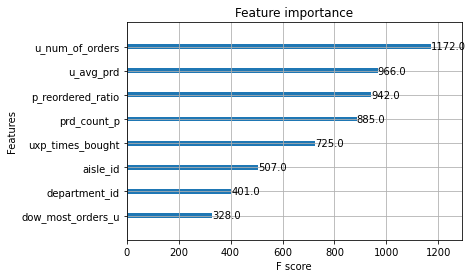

In [ ]:
# Build XGBoost model
#setting boosters parameters
parameters = {
    'eval_metric' : 'logloss',
    'max_depth' : 5,
    'colsample_bytree' : 0.4,
    'subsample' : 0.8
}

#instantiating the model
xgb_clf = xgb.XGBClassifier(objective='binary:logistic', parameters=parameters, num_boost_round=10)

# TRAIN MODEL
model = xgb_clf.fit(X_train, y_train)

#FEATURE IMPORTANCE - GRAPHICAL
xgb.plot_importance(model)

In [ ]:
#predicting on the testing data
y_pred = xgb_clf.predict(data_test).astype('int')

#setting a threshold.
y_pred = (xgb_clf.predict_proba(data_test)[:, 1] >= 0.21).astype('int')
y_pred[0:10]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 1])

In [ ]:
#saving the prediction as a new column in data_test
data_test['prediction'] = y_pred
data_test.head()

uxp_times_bought  uxp_reordered_ratio  u_num_of_orders  \
user_id product_id                                                           
3       248                        1             0.000000               12   
        1005                       1             0.000000               12   
        1819                       3             0.666667               12   
        7503                       1             0.000000               12   
        8021                       1             0.000000               12   

                    u_avg_prd  dow_most_orders_u  prd_count_p  \
user_id product_id                                              
3       248          7.333333                  0         6371   
        1005         7.333333                  0          463   
        1819         7.333333                  0         2424   
        7503         7.333333                  0        12474   
        8021         7.333333                  0        27864   

                    p_reordered_ratio  aisle_id  department_id  prediction  
user_id product_id                                                          
3       248                  0.400251       117             19           0  
        1005                 0.440605        94              7           0  
        1819                 0.492162        88             13           0  
        7503                 0.553551       117             19           0  
        8021                 0.591157        54             17           0

In [ ]:
# Reset the index
final = data_test.reset_index()
# Keep only the required columns to create our submission file
final = final[['product_id', 'user_id', 'prediction']]

#gc.collect()
final.head()

,product_id,user_id,prediction
0,248,3,0
1,1005,3,0
2,1819,3,0
3,7503,3,0
4,8021,3,0


In [ ]:
orders = pd.read_csv('../../data/orders.csv')

In [ ]:
#Creating a submission file
PATH = '../../data/'
orders = pd.read_csv(PATH + 'orders.csv')
orders_test = orders.loc[orders.eval_set == 'test', ['user_id', 'order_id']]
orders_test.head()

,user_id,order_id
2,3,2774568
3,4,329954
5,6,1528013
10,11,1376945
11,12,1356845


In [ ]:
#merging our prediction with orders_test
final = final.merge(orders_test, on='user_id', how='left')
final.head()

,product_id,user_id,prediction,order_id
0,248,3,0,2774568
1,1005,3,0,2774568
2,1819,3,0,2774568
3,7503,3,0,2774568
4,8021,3,0,2774568


In [ ]:
#remove user_id column
final = final.drop('user_id', axis=1)

In [ ]:
#convert product_id as integer
final['product_id'] = final.product_id.astype(int)

## Remove all unnecessary objects
#del orders
#del orders_test
#gc.collect()

final.head()

,product_id,prediction,order_id
0,248,0,2774568
1,1005,0,2774568
2,1819,0,2774568
3,7503,0,2774568
4,8021,0,2774568
